In [1]:
import numpy as np
np.set_printoptions(threshold = np.nan, linewidth = 115)
import pickle
import keras
from keras import models, optimizers, layers, regularizers, metrics, losses
from keras.layers.advanced_activations import LeakyReLU, PReLU, ELU, ReLU, ThresholdedReLU
from keras.layers.core import Dense, Dropout, SpatialDropout2D, Activation
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.models import model_from_json, Sequential

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config = config)

import matplotlib.pyplot as plt

IMG_SIZE = 256

# Save Comparison model
def save_model(model_name, hist_str, model_str):

    pickle.dump(model_name.history, open('Training Histories/'+ hist_str + '.p', 'wb'))
    
    print("Saved " + hist_str + " to Training Histories folder")
    
    # serialize model to JSON
    model_name = model.to_json()
    with open("CNN Models/" + model_str + ".json", "w") as json_file:
        json_file.write(model_name)

    # serialize weights to HDF5
    model.save_weights("CNN Models/" + model_str + ".h5")
    print("Saved " + model_str + " and weights to CNN Models folder")
    
# Load model architecture and weights NOTE: must compile again
def load_model():
    model_str = str(input("Name of model to load: "))

    # load json and create model
    json_file = open('CNN Models/' + model_str + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("CNN Models/" + model_str + ".h5")
    print("Loaded " + model_str + " and weights from CNN Models folder")
    
    return loaded_model
    
# Load history object
def load_history():
    hist_str = str(input("Name of history to load: "))

    loaded_history = pickle.load(open('Training Histories/' + hist_str + '.p', 'rb'))
    
    print("Loaded " + hist_str + " from Training Histories folder")
    
    return loaded_history

Infiltration_class_weight = [{0: 1, 1: 12.9379183014078}]

Using TensorFlow backend.


In [2]:
# Load with pickle instead of processing images again
training_img_1 = pickle.load(open('1vAll_img_res_Infiltration_1st_half.p', 'rb'))
training_img_2 = pickle.load(open('1vAll_img_res_Infiltration_2nd_half.p', 'rb'))

training_img = np.append(training_img_1, training_img_2, axis = 0)

test_img = pickle.load(open('1vAll_test_img.p', 'rb'))

labels_1 = pickle.load(open('1vAll_labels_res_Infiltration_1st_half.p', 'rb'))
labels_2 = pickle.load(open('1vAll_labels_res_Infiltration_2nd_half.p', 'rb'))

training_labels = np.append(labels_1, labels_2, axis = 0)

test_labels = pickle.load(open('1vAll_test_labels.p', 'rb'))    

In [3]:
Infiltration_labels = training_labels[:, 8]
print('Labels shape: ', Infiltration_labels.shape)
print('Length of test_labels: ', len(test_labels))
print('No. of Infiltration Diagnoses: ', sum(Infiltration_labels))

Labels shape:  (46184,)
Length of test_labels:  3490
No. of Infiltration Diagnoses:  18149


In [4]:
# Metric Analysis
def _1vAll_accuracy(y_test, pred):
    
    pred = np.squeeze(pred, axis = -1)
    pred = np.round_(pred)
    pred = pred.astype(dtype = 'uint8')
    
    ft = pred == y_test
    
    accuracy = sum(ft)/len(ft)
        
    print('\t Complete Label Accuracy: ', (accuracy * 100), '%')
    
    print('Sum of Fully Correct Predictions: ', sum(ft))
    print('\t\t    Total Labels: ', len(ft))
    
    return accuracy

### One Vs. All

Name of model to load: Infiltration_1vAll_Reg_50e
Loaded Infiltration_1vAll_Reg_50e and weights from CNN Models folder
Train on 40411 samples, validate on 5773 samples
Epoch 51/75
40411/40411 [==============================] - 80s 2ms/step - loss: 0.6592 - acc: 0.6364 - val_loss: 0.6961 - val_acc: 0.6194
Epoch 52/75
40411/40411 [==============================] - 81s 2ms/step - loss: 0.6550 - acc: 0.6403 - val_loss: 0.7125 - val_acc: 0.5789
Epoch 53/75
40411/40411 [==============================] - 83s 2ms/step - loss: 0.6557 - acc: 0.6411 - val_loss: 0.7076 - val_acc: 0.5971
Epoch 54/75
40411/40411 [==============================] - 83s 2ms/step - loss: 0.6545 - acc: 0.6405 - val_loss: 0.7054 - val_acc: 0.5993
Epoch 55/75
40411/40411 [==============================] - 86s 2ms/step - loss: 0.6532 - acc: 0.6418 - val_loss: 0.7047 - val_acc: 0.5954
Epoch 56/75
40411/40411 [==============================] - 86s 2ms/step - loss: 0.6556 - acc: 0.6437 - val_loss: 0.7128 - val_acc: 0.5782
Epoc

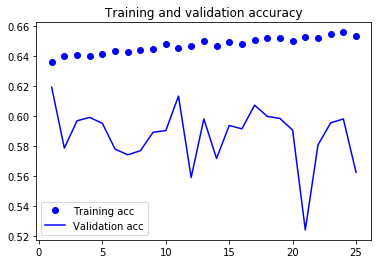

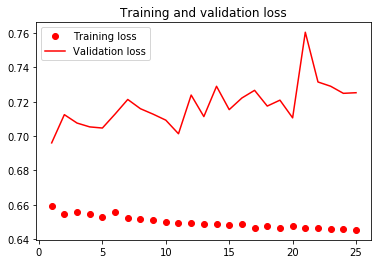

In [5]:
# Last model: Infiltration_1vAll_Reg_50e
model = load_model()
#model.summary()

model.compile(optimizer = optimizers.RMSprop(lr = 1e-3), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model_obj = model.fit(training_img, Infiltration_labels, 
                      epochs = 75, initial_epoch = 50, 
                      validation_split = (1 / 8), 
                      batch_size = 128, verbose = 1 )
                     #, class_weight = Infiltration_class_weight)

Predictions = model.predict(test_img)

Accuracy = _1vAll_accuracy(test_labels, Predictions)

history_str = 'Infiltration_1vAll_Reg_75e_history'
model_str   = 'Infiltration_1vAll_Reg_75e'
    
save_model(model_obj, history_str, model_str)

acc = model_obj.history['acc']
val_acc = model_obj.history['val_acc']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Train on 40411 samples, validate on 5773 samples
Epoch 1/30
40411/40411 [==============================] - 176s 4ms/step - loss: 5.8842 - acc: 0.4994 - val_loss: 10.1245 - val_acc: 0.3691
Epoch 2/30
40411/40411 [==============================] - 173s 4ms/step - loss: 1.2916 - acc: 0.5919 - val_loss: 0.8195 - val_acc: 0.6309
Epoch 3/30
40411/40411 [==============================] - 185s 5ms/step - loss: 1.8374 - acc: 0.5902 - val_loss: 5.9970 - val_acc: 0.6309
Epoch 4/30
40411/40411 [==============================] - 183s 5ms/step - loss: 3.7917 - acc: 0.5718 - val_loss: 0.7221 - val_acc: 0.6309
Epoch 5/30
40411/40411 [==============================] - 187s 5ms/step - loss: 2.6331 - acc: 0.5708 - val_loss: 0.7169 - val_acc: 0.6309
Epoch 6/30
40411/40411 [==============================] - 188s 5ms/step - loss: 2.8855 - acc: 0.5800 - val_loss: 10.0816 - val_acc: 0.3691
Epoch 7/30
40411/40411 [==============================] - 192s 5ms/step - loss: 1.2686 - acc: 0.5831 - val_loss: 0.6778 -

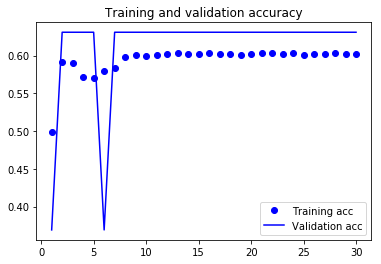

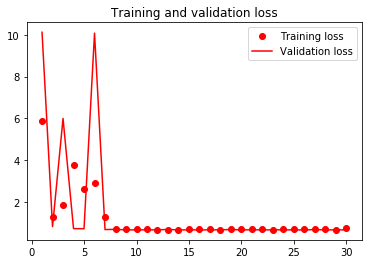

In [6]:
# One Vs. All - Inception Model
# v3: Added layers
# v4: L2 Regularized
# v5: Replaced Separable with Conv2D

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='elu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 1), 
                        kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.375))
model.add(layers.Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.375))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dense(1, activation='sigmoid'))

# Last model: 1vAll_Inception_v5_30e
#model = load_model()
#model.summary()

model.compile(optimizer = optimizers.RMSprop(lr = 1e-3), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model_obj = model.fit(training_img, Infiltration_labels, 
                      epochs = 30, initial_epoch = 0, 
                      validation_split = (1 / 8), 
                      batch_size = 64, verbose = 1 )

Predictions = model.predict(test_img)

Accuracy = _1vAll_accuracy(test_labels, Predictions)

history_str = '1vAll_Inception_v5_30e_history'
model_str   = '1vAll_Inception_v5_30e'
    
save_model(model_obj, history_str, model_str)

acc = model_obj.history['acc']
val_acc = model_obj.history['val_acc']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# One Vs. All - Inception Model
# v2: No Class Weights, Added Separable and Dense Layer

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='selu', 
                        kernel_regularizer=regularizers.l2(0.005), 
                        input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.375))
model.add(layers.SeparableConv2D(16, (3, 3), activation='selu', 
                        kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.SeparableConv2D(16, (3, 3), activation='selu', 
                                 kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.375))

model.add(layers.Flatten())
model.add(layers.Dense(16, activation='selu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dense(4, activation='selu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dense(1, activation='sigmoid'))

Train on 40411 samples, validate on 5773 samples
Epoch 1/30
40411/40411 [==============================] - 208s 5ms/step - loss: 0.7861 - acc: 0.5906 - val_loss: 0.7100 - val_acc: 0.6257
Epoch 2/30
40411/40411 [==============================] - 215s 5ms/step - loss: 0.7199 - acc: 0.6012 - val_loss: 0.6892 - val_acc: 0.6329
Epoch 3/30
40411/40411 [==============================] - 209s 5ms/step - loss: 0.7008 - acc: 0.6036 - val_loss: 0.6986 - val_acc: 0.6336
Epoch 4/30
40411/40411 [==============================] - 204s 5ms/step - loss: 0.7023 - acc: 0.6031 - val_loss: 0.6841 - val_acc: 0.6317
Epoch 5/30
40411/40411 [==============================] - 204s 5ms/step - loss: 0.6929 - acc: 0.6049 - val_loss: 0.6972 - val_acc: 0.5839
Epoch 6/30
40411/40411 [==============================] - 211s 5ms/step - loss: 0.6895 - acc: 0.6045 - val_loss: 0.6879 - val_acc: 0.6286
Epoch 7/30
40411/40411 [==============================] - 207s 5ms/step - loss: 0.6887 - acc: 0.6087 - val_loss: 0.6879 - v

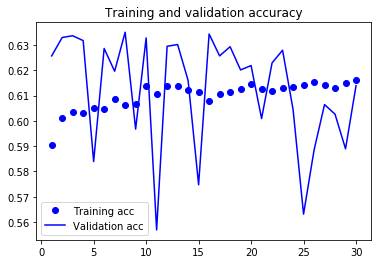

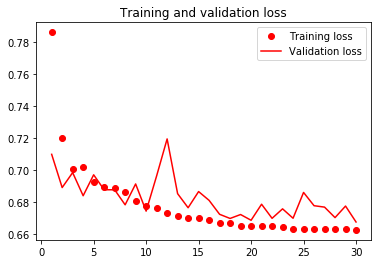

In [7]:
# Last model: 1vAll_Inception_v2_30e
model = load_model()
#model.summary()

model.compile(optimizer = optimizers.RMSprop(lr = 1e-3), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model_obj = model.fit(training_img, Infiltration_labels, 
                      epochs = 50, initial_epoch = 30, 
                      validation_split = (1 / 8), 
                      batch_size = 64, verbose = 1)

Predictions = model.predict(test_img)

Accuracy = _1vAll_accuracy(test_labels, Predictions)

history_str = '1vAll_Inception_v2_50e_history'
model_str   = '1vAll_Inception_v2_50e'
    
save_model(model_obj, history_str, model_str)

acc = model_obj.history['acc']
val_acc = model_obj.history['val_acc']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# One Vs. All - Inception Model
# v2: No Class Weights, Added Separable and Dense Layer
# v3: Regularizer constant 0.005 -> 0.01, added Spatial Dropout and changed Rates

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='selu', 
                        kernel_regularizer=regularizers.l2(0.01), 
                        input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.5))
model.add(layers.SeparableConv2D(16, (3, 3), activation='selu', 
                        kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.5))
model.add(layers.SeparableConv2D(16, (3, 3), activation='selu', 
                                 kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(16, activation='selu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(4, activation='selu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(1, activation='sigmoid'))

# Last model: 1vAll_Inception_v3_30e
#model = load_model()
#model.summary()

model.compile(optimizer = optimizers.RMSprop(lr = 1e-3), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model_obj = model.fit(training_img, Infiltration_labels, 
                      epochs = 50, initial_epoch = 0, 
                      validation_split = (1 / 8), 
                      batch_size = 64, verbose = 1)

Predictions = model.predict(test_img)

Accuracy = _1vAll_accuracy(test_labels, Predictions)

history_str = '1vAll_Inception_v3_50e_history'
model_str   = '1vAll_Inception_v3_50e'
    
save_model(model_obj, history_str, model_str)

acc = model_obj.history['acc']
val_acc = model_obj.history['val_acc']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()